In [4]:
import pandas
import pm4py
from nltk.cluster import KMeansClusterer
import nltk 
from sklearn import cluster
from sklearn import metrics
import time
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


In [5]:
event_log = pandas.read_csv('TJSP-BL-event-log.csv', sep=',')
#event_log = pandas.read_csv('TJSP.csv', sep=',')
#lawsuit_id,date,movement,order,status,area,subject_matter,control,digital,class,distribution_date,court_department,claim_amount,judge
event_log = pm4py.format_dataframe(event_log, case_id='lawsuit_id', activity_key='movement', timestamp_key='date')
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
#print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
# the log is filtered on the top 5 variants
filtered_log = pm4py.filter_variants_top_k(event_log , 5)

In [ ]:
event_log.head()

In [12]:
def retrieve_traces(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(["".join(x) for x in events])
        ids.append(id)

    return ids, traces

def extract_corpus(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(" ".join(x.replace(" ", "") for x in events))
        ids.append(id)

    return ids, traces

def run_doc2vec(config, log):
    ids, traces = retrieve_traces(log)
    start_time = time.time()
    tagged_traces = [TaggedDocument(words=act, tags=[str(i)]) for i, act in enumerate(traces)]
    
    # generate model
    model = Doc2Vec(vector_size=config["vector_size"], min_count=1, window=3, dm=1, workers=-1)
    #model = Doc2Vec(vector_size=100, min_count=1, window=3, dm=1, workers=-1)
    model.build_vocab(tagged_traces)
    vectors = [model.infer_vector(trace) for trace in traces]

    end_time = time.time() - start_time
    print(f"\nDoc2vec took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(config["vector_size"])])
    #encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(100)])
    #encoded_df.insert(0, "case", ids)

    return encoded_df

def run_tfidf(config, log):
    ids, traces = extract_corpus(log)
    start_time = time.time()

    # generate model
    model = TfidfVectorizer()
    encoding = model.fit_transform(traces)

    end_time = time.time() - start_time
    print(f"\nTFIDF took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(encoding.toarray(), columns=[f"{i}" for i in range(encoding.toarray().shape[1])])
    #encoded_df.insert(0, "case", ids)

    return encoded_df

def create_cluster_kmeans(vectors):
    NUM_CLUSTERS=5
    kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    l = kmeans.fit_predict(vectors)
    pca = PCA(n_components=2).fit(vectors)
    datapoint = pca.transform(vectors)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#800d00"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()

     
    print ("[KM]Cluster id labels for inputted data")
    print (labels)
    print ("[KM]Centroids data")
    print (centroids)
     
    print ("[KM]Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
    print (kmeans.score(vectors))
     
    silhouette_score = metrics.silhouette_score(vectors, labels, metric='euclidean')
     
    print ("[KM]Silhouette_score: ")
    print (silhouette_score)

def create_cluster_dbscam(vectors):
    NUM_CLUSTERS=5

    db = DBSCAN(eps=0.3, min_samples=5).fit(vectors)
    labels = db.labels_
    #centroids = db.cluster_centers_

    l = db.fit_predict(vectors)
    pca = PCA(n_components=2).fit(vectors)
    datapoint = pca.transform(vectors)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#800d00"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    #centroidpoint = pca.transform(centroids)
    #plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()

     
    print ("[DBSCAM]Cluster id labels for inputted data")
    print (labels)
    #print ("[DBSCAM]Centroids data")
    #print (centroids)
     
    #print ("[DBSCAM]Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
    #print (db.score(vectors))
     
    #silhouette_score = metrics.silhouette_score(vectors, labels, metric='euclidean')
     
    #print ("[DBSCAM]Silhouette_score: ")
    #print (silhouette_score)


Doc2vec took 1.11 seconds


/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


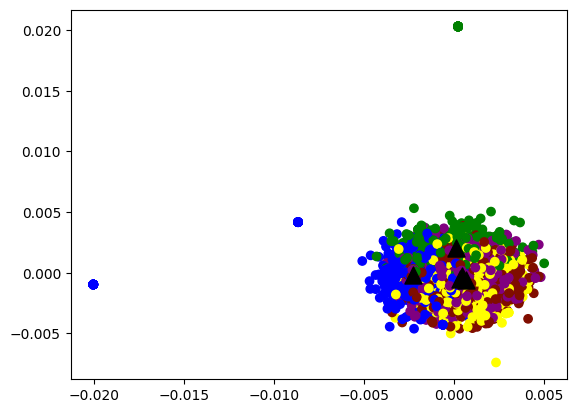

[KM]Cluster id labels for inputted data
[1 2 4 ... 0 4 2]
[KM]Centroids data
[[ 1.16115254e-04  4.76402201e-05  5.13563391e-05  1.95701177e-05
   1.10764922e-05 -1.34632734e-04 -2.00158145e-04 -1.86256424e-04
  -8.41530418e-05 -2.34611449e-04  1.42374163e-04  1.73977343e-04
   3.62923784e-05 -1.09485918e-04  2.03942720e-04  1.58616982e-04
   1.46428356e-04 -8.87982533e-05  1.18522650e-04 -6.33767413e-05
  -1.69157312e-04  4.32165034e-05  2.28494260e-04  2.64269802e-05
   2.56499567e-04 -1.36151924e-04  7.76807865e-05  2.64875387e-04
   6.42696250e-05  1.54878217e-04 -5.43457145e-06  1.33312069e-05
   2.22764022e-04 -1.10581408e-04 -2.21508555e-04  6.26215624e-05
  -2.39996749e-04  1.37382158e-04  1.04162573e-04  1.45730271e-04
  -1.09304347e-05 -4.27054256e-05 -8.72558667e-05 -7.93339204e-05
   2.72677047e-04  1.71243417e-04  9.31726536e-05 -7.18908923e-05
  -3.21236177e-04 -4.27582127e-04  2.43325285e-05  1.03750703e-04
  -5.84579975e-05  1.72639338e-05  8.23078008e-05 -6.64381296e-05

/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


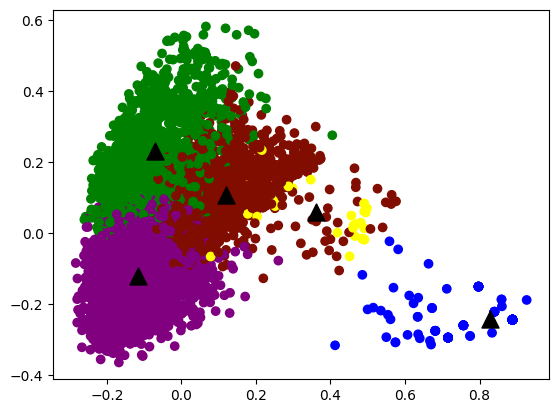

[KM]Cluster id labels for inputted data
[4 1 4 ... 3 1 3]
[KM]Centroids data
[[ 3.38813179e-21  0.00000000e+00  8.67361738e-19 ...  0.00000000e+00
   8.67361738e-19  0.00000000e+00]
 [ 2.71050543e-20 -8.13151629e-20  4.60220685e-04 ...  2.24510262e-04
   4.60220685e-04  2.32031670e-04]
 [-6.77626358e-21 -2.71050543e-20 -8.67361738e-19 ...  0.00000000e+00
  -8.67361738e-19  5.42101086e-20]
 [ 5.80475198e-05  2.30392962e-19  5.33302117e-03 ...  5.17439865e-05
   5.33302117e-03  1.30957608e-04]
 [ 1.01643954e-20  2.44181528e-04  3.62330976e-05 ...  1.92738479e-02
   3.62330976e-05 -9.48676901e-20]]
[KM]Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-2136.3806813555643
[KM]Silhouette_score: 
0.09673729113193777


In [16]:
config = {
  "vector_size": 200
}

encoding1 = run_doc2vec(config, event_log)
#print(encoding)
create_cluster_kmeans(encoding1)
#create_cluster_dbscam(encoding1)

encoding2 = run_tfidf(config, event_log)
#print(encoding2)
create_cluster_kmeans(encoding2)
#create_cluster_dbscam(encoding2)
